## qDESS T2 and Diffusivity mapping
###### Author: Zimu Huo
###### Date: 03.2022

T2 and Diffusivity mapping based on nonlinear regression. 

Special thanks to Michael and Neal for sending me the resources 

-------------------------------------------------------------------------
References
    
    [1] 
    Author: Ernesto Staroswiecki et al. 
    Title: Simultaneous Estimation of T2 and Apparent Diffusion Coefficient in Human Articular 
            Cartilage In Vivo with a Modified Three-Dimensional Double Echo Steady State (DESS) Sequence at 3 T
    Link: https://pubmed.ncbi.nlm.nih.gov/22179942/

In [2]:
import os 
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
import pydicom as dcm
import math
from numpy import sqrt, sin, cos, pi, exp, log
from scipy.optimize import fsolve

In [3]:
filePath = "src/spoil30"
data = Path(filePath)
dirs = list(data.glob('**/*.IMA'))
file0 = dcm.read_file(dirs[0]) 
f = file0.pixel_array
[height, width] = f.shape
N = len(dirs)
del file0
del f

images = np.zeros([height,width,N])
for index,f in enumerate (dirs):
    image = dcm.read_file(f).pixel_array
    images[:,:,index] = image
dess1 = np.zeros([height,width,int(N/2),2])
dess1[:,:,:,0] = images[:,:,0:int(N/2)]+ 0.0000000000000001
dess1[:,:,:,1] = images[:,:,int(N/2):] 
del images

filePath = "src/spoil50"
data = Path(filePath)
dirs = list(data.glob('**/*.IMA'))
images = np.zeros([height,width,N])
for index,f in enumerate (dirs):
    image = dcm.read_file(f).pixel_array
    images[:,:,index] = image
dess2 = np.zeros([height,width,int(N/2),2])
dess2[:,:,:,0] = images[:,:,0:int(N/2)] + 0.0000000000000001
dess2[:,:,:,1] = images[:,:,int(N/2):]
del images

In [4]:
filePath = "src/spoil30"
data = Path(filePath)
dirs = list(data.glob('**/*.IMA'))
file1 = dcm.read_file(dirs[0]) 
Glarea1 = 30*1e2

TR1 = file1.RepetitionTime*1e-3
TE1 = file1.EchoTime*1e-3
tau1 = 4.8e-3
alpha1 = file1.FlipAngle
G1 = Glarea1 /(tau1*1e6)*100

In [5]:
filePath = "src/spoil50"
data = Path(filePath)
dirs = list(data.glob('**/*.IMA'))
file2 = dcm.read_file(dirs[0]) 
Glarea2 = 50*1e2

TR2 = file2.RepetitionTime*1e-3
TE2 = file2.EchoTime*1e-3
tau2 = 4.8e-3
alpha2 = file2.FlipAngle
G2 = Glarea2 /(tau2*1e6)*100

In [6]:
def qDESS(p,*data):
    D,T2 = p
    arg = data[0]
    sp,sm,TR,TE,tau,alpha,Gl = arg
    ratio = sm/sp
    gamma = 4258*2*np.pi
    dkL = gamma*Gl*tau
    T1 = 1.2
    k = ((math.sin(math.radians(alpha/2))))**2*((1 + np.exp(-TR/T1 - TR*dkL**2*D)))/(1 - (math.cos(math.radians(alpha)))*exp(-TR/T1 - TR*dkL**2*D))
    c1 = (TR-tau/3)*dkL**2*D
    return ((-2000*(TR-TE)/(log(abs(ratio)/k)+c1))-T2),((-2000*(TR-TE)/(log(abs(ratio)/k)+c1))-T2)

In [7]:
D_map = np.zeros([height,width,int(N/2)])
T2_map = np.zeros([height,width,int(N/2)])
i = 80
for y in range(height):
    for x in range(width):
        sp1 = dess1[y,x,i,0]
        sm1 = dess1[y,x,i,1]
        sp2 = dess2[y,x,i,0]
        sm2 = dess2[y,x,i,1]
        data1 = (sp1,sm1,TR1,TE1,tau1,alpha1,G1)
        data2 = (sp2,sm2,TR2,TE2,tau2,alpha2,G2)
        D,T2 = fsolve(qDESS, [10**(-10), 20],args=(data1,data2))
        D_map[y,x,i] = D
        T2_map[y,x,i] = T2

/var/folders/5d/6p36mvb505x5j7b_90jtxdsr0000gn/T/ipykernel_78253/3516149072.py:11: RuntimeWarning: divide by zero encountered in log
  return ((-2000*(TR-TE)/(log(abs(ratio)/k)+c1))-T2),((-2000*(TR-TE)/(log(abs(ratio)/k)+c1))-T2)
/var/folders/5d/6p36mvb505x5j7b_90jtxdsr0000gn/T/ipykernel_78253/3516149072.py:11: RuntimeWarning: invalid value encountered in log
  return ((-2000*(TR-TE)/(log(abs(ratio)/k)+c1))-T2),((-2000*(TR-TE)/(log(abs(ratio)/k)+c1))-T2)
/Users/huozimu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


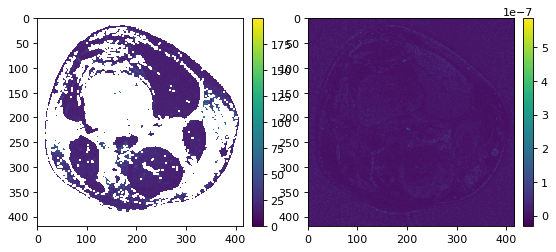

In [8]:
i = 80
T2_map[T2_map <=0] = np.NaN;
T2_map[T2_map > 200] = np.NaN;
plt.figure(figsize=(8, 6), dpi=80)
plt.subplot(121)
tf = plt.imshow(T2_map[:,:,i])
plt.colorbar(tf, fraction=0.046, pad=0.04)
plt.subplot(122)
tf = plt.imshow(D_map[:,:,i])
plt.colorbar(tf, fraction=0.046, pad=0.04)
plt.show()